In [1]:
import Pkg
Pkg.activate("..")

using MolecularGraph
using MolecularGraph.Geometry

┌ Info: Recompiling stale cache file /Users/smatsuoka/.julia/compiled/v1.0/MolecularGraph/6vz1i.ji for MolecularGraph [6c89ec66-9cd8-5372-9f91-fabc50dd27fd]
└ @ Base loading.jl:1187


loading: funcgroup.yaml
loading: ring.yaml
loading: biomolecule.yaml


In [200]:
using MolecularGraph.Graph
using LinearAlgebra

mutable struct ForceDirectedState{G<:UDGraph}
    graph::G

    velo::Matrix{Float64}
    force::Matrix{Float64}
    maxiter::Int
    tick::Float64
    stdlength::Float64
    stdangle::Float64
    repulsion::Float64
    spring::Float64
    hinge::Float64
    decay::Float64

    coords::Matrix{Float64}

    function ForceDirectedState{G}(graph, init) where {G<:UDGraph}
        state = new()
        initmat = rawdata(init)
        state.coords = deepcopy(initmat)
        state.velo = zeros(size(initmat))
        state.force = zeros(size(initmat))
        state.maxiter = 50
        state.tick = 0.01
        state.stdlength = 1.0
        state.stdangle = -2/3
        state.repulsion = 0.01
        state.spring = 2.0
        state.hinge = 0.002
        state.decay = 0.9
        return state
    end
end



"""
    forcedirected(graph::UDGraph) -> Cartesian2D

Compute 2D embedding based on the graph distance.
"""
function Geometry.forcedirected(graph::G, init::Cartesian2D) where {G<:UDGraph}
    state = ForceDirectedState{G}(graph, init)
    t = state.tick
    for i in 1:state.maxiter
        energy = 0.0
        for n1 in nodekeys(graph)
            p1v = state.velo[n1, :] * t
            p1a = state.force[n1, :] * (t ^ 2) * 0.5
            state.coords[n1, :] +=  p1v + p1a
            p1 = state.coords[n1, :]
            force = [0.0, 0.0]
            # Repulsion constraints
            for n2 in nodekeys(graph)
                n2 == n1 && continue
                p2 = state.coords[n2, :]
                factor = min(state.repulsion / norm(p2 - p1) ^ 2, state.repulsion * 100)
                force -= factor * normalize(p2 - p1)
            end
            # Spring constraint
            for nbr in neighborkeys(graph, n1)
                pnbr = state.coords[nbr, :]
                factor = (norm(pnbr - p1) - state.stdlength) * state.spring
                force += factor * normalize(pnbr - p1)
            end
            """
            # Hinge constraint
            for (a, b) in combinations(neighbors(graph, n1))
                pa = state.coords[a, :]
                pb = state.coords[b, :]
                factor = (interiorangle(pa, pb) - state.stdangle) * state.hinge
                force += factor * normalize(p2 - p1)
            end
            """
            state.velo[n1, :] += (state.force[n1, :] + force) / 2 * t
            state.force[n1, :] = force
            energy += norm(state.force[n1, :])
        end
        println(energy)
        energy < 0.001 && break
    end
    return Cartesian2D(state.coords)
end


MolecularGraph.Geometry.forcedirected

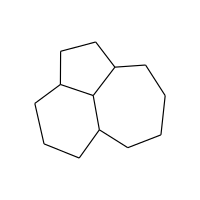

9.648375049739974
9.648300223522545
9.646890262972473
9.644142265679431
9.640052766867738
9.634617742332447
9.627832611434311
9.619692240350897
9.610190945831274
9.599322499747707
9.587080134778756
9.573456551592736
9.558443927928131
9.542033929986607
9.524217726564073
9.504986006344247
9.484328998766046
9.462236498849622
9.438697896323804
9.413702209338886
9.387238122970404
9.35929403262028
9.3298580922988
9.298918267622312
9.266462393185979
9.232478233766832
9.19695354858085
9.15987615756122
9.121234008350031
9.081015242413363
9.039208258419203
8.995801770786246
8.950784861160345
8.904147020558252
8.855878180107958
8.805968728799712
8.754409517546918
8.701191850255604
8.646307464628883
8.589748508182947
8.53150751847782
8.471577420851842
8.409951561879975
8.346623802118485
8.281588697087848
8.21484180039805
8.146380126852309
8.076202815619327
8.004312033404616
7.9307141540961235


In [205]:
mol = smilestomol("C1CCC2CCC3CCCCC1C23")
coords = graphdistembedding(mol)
opt =  forcedirected(mol, coords)
mol.coords[:Cartesian2D] = opt
mol_svg = drawsvg!(mol, 200, 200)
display("image/svg+xml",  mol_svg)